# Give Me Some Credit
Kaggle에서 2011년에 진행된 데이터 과학 경진대회로,
참가자들은 고객이 향후 2년 내에 심각한 연체(90일 이상 지불 지연)을 겪을 확률을 예측하는
이진 분류 문제에 도전했습니다.

## 1. 대회 개요
    - 목표: 
        향후 2년 내에 고객이 심각한 연체(Serious Delinquency in 2 Years,    SeriousDlqin2yrs)를 겪을 확률을 예측하는 이진 분류 문제.
    - 문제 배경: 
        신용 평가 기술을 개선하여 금융 기관이 고객의 재정적 어려움 가능성을 더 정확히 예측하도록 돕는 것. 이는 대출 승인 및 리스크 관리에 활용됩니다.
    - 데이터 제공: 
        익명화된 11개 피처로 구성된 고객 데이터. 피처는 신용 관련 정보를 나타내며, 일부는 결측값과 이상치를 포함.
    - 평가 지표: 
        ROC-AUC (Receiver Operating Characteristic - Area Under Curve). 예측 확률과 실제 타겟 간의 ROC 곡선 아래 면적을 기준으로 모델 성능을 평가.
    - 대회 기간: 2011년 약 3개월간 진행.
    - 데이터 크기: 약 15MB (압축 시 5MB).

## 2. 데이터셋 분석
- 데이터 구조:
    - 훈련 데이터: 
        150,000개 샘플, 11개 피처 (1개 타겟 변수: SeriousDlqin2yrs, 10개 설명 변수).
        - 타겟 변수: SeriousDlqin2yrs (0: 연체 없음, 1: 연체 있음).
        - 클래스 불균형: 
            약 6.7%가 긍정 클래스(1), 즉 10,026개 샘플이 긍정, 139,974개가 부정
            (1:14 비율)
    - 테스트 데이터: 101,503개 샘플, 동일한 10개 설명 변수.
    - 피처:
        - RevolvingUtilizationOfUnsecuredLines: 신용 한도 대비 사용 금액 비율.
        - age: 고객 나이.
        - NumberOfTime30-59DaysPastDueNotWorse: 30~59일 연체 횟수.
        - DebtRatio: 부채 비율.
        - MonthlyIncome: 월 소득 (결측값 29,731개, 약 19.8%).
        - NumberOfOpenCreditLinesAndLoans: 개설된 신용 한도 및 대출 수.
        - NumberOfTimes90DaysLate: 90일 이상 연체 횟수.
        - NumberOfTime60-89DaysPastDueNotWorse: 60~89일 연체 횟수.
        - NumberOfDependents: 부양 가족 수 (결측값 약 2.6%).
        - RealEstateLoansOrLines: 부동산 대출 또는 신용 한도 수.
        - Unnamed: 추가 익명화된 피처.
    - 데이터 특성:
        - 결측값: MonthlyIncome (19.8%)과 NumberOfDependents (2.6%)에 결측값 존재.
    - 이상치:
        - age: 최소값 0 (오류로 간주, 21세 이상으로 조정 권장).
        - NumberOfTime30-59DaysPastDueNotWorse, 
          NumberOfTimes90DaysLate,
          NumberOfTime60-89DaysPastDueNotWorse: 96, 98 값이 비정상적으로 나타남 
          (의미 불명, Winsorization 또는 중앙값 대체 권장).
    - 상관관계: 
        연체 관련 피처들(30-59일, 60-89일, 90일 이상) 간 강한 상관관계 존재. 
        이상치 제거 후 상관관계 감소.
    - 클래스 불균형: 긍정 클래스(1)가 6.7%로, 불균형 데이터 처리 필요.

In [2]:
import os
print(os.getcwd())
print(os.listdir())

d:\workspace\hit_ml_dl\practice
['credit.ipynb', 'data', 'data_dictionary.png', 'heart.ipynb', 'heart_optuna.ipynb', 'linear_regression', 'mushroom.ipynb', 'santander.ipynb', 'santander_fixed.py', 'stroke.ipynb', 'stroke_fixed.py', 'titanic.ipynb']


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 1. 데이터 로드
train_data = pd.read_csv("./data/GiveMeSomeCredit/cs-training.csv", encoding='utf-8')
test_data = pd.read_csv("./data/GiveMeSomeCredit/cs-test.csv", encoding='utf-8')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [6]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [8]:
# 2. 데이터 전처리
# 2.1 결측값 처리
# MonthlyIncome: 19.8% 결측, 중앙값으로 대체
train_data['MonthlyIncome'].fillna(train_data['MonthlyIncome'].median(), inplace=True)
test_data['MonthlyIncome'].fillna(test_data['MonthlyIncome'].median(), inplace=True)

# NumberOfDependents: 2.6% 결측, 중앙값으로 대체
train_data['NumberOfDependents'].fillna(train_data['NumberOfDependents'].median(), inplace=True)
test_data['NumberOfDependents'].fillna(test_data['NumberOfDependents'].median(), inplace=True)

C:\Users\wsm\AppData\Local\Temp\ipykernel_23984\403855954.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['MonthlyIncome'].fillna(train_data['MonthlyIncome'].median(), inplace=True)
C:\Users\wsm\AppData\Local\Temp\ipykernel_23984\403855954.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

In [13]:
# 2.2 이상치 처리
# 연체 횟수 피처(96, 98값)를 중앙값으로 대체
for col in ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 
            'NumberOfTime60-89DaysPastDueNotWorse']:
    train_data[col] = train_data[col].replace([96, 98], train_data[col].median())
    test_data[col] = test_data[col].replace([96, 98], test_data[col].median())

# age=0을 평균으로 대체 (비현실적 값)
train_data.loc[train_data['age'] == 0, 'age'] = train_data['age'].mean()
test_data.loc[test_data['age'] == 0, 'age'] = test_data['age'].mean()

In [16]:
# 2.3 피처와 타겟 분리
X = train_data.drop(['Unnamed: 0', 'SeriousDlqin2yrs'], axis=1)  # ID와 타겟 제거
y = train_data['SeriousDlqin2yrs']  # 타겟 변수
X_test = test_data.drop(['Unnamed: 0', 'SeriousDlqin2yrs'], axis=1)  # 테스트 데이터

In [17]:
# 2.4 피처 스케일링 (Logistic Regression에 유리)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

In [18]:
# 3. 데이터 분할 (훈련/검증)
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [19]:
# 4. 모델 설계 및 학습
# 클래스 불균형(6.7% 긍정 클래스)을 위해 class_weight='balanced' 사용
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [20]:
# 5. 예측 및 평가
y_pred_proba = model.predict_proba(X_val)[:, 1]  # 클래스 1(연체)에 대한 확률
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f"ROC-AUC 점수: {roc_auc:.4f}")

ROC-AUC 점수: 0.8205


In [21]:
# 6. 피처 중요도 계산 (퍼뮤테이션 중요도)
perm_importance = permutation_importance(
    model, X_val, y_val, n_repeats=10, random_state=42, scoring='roc_auc'
)

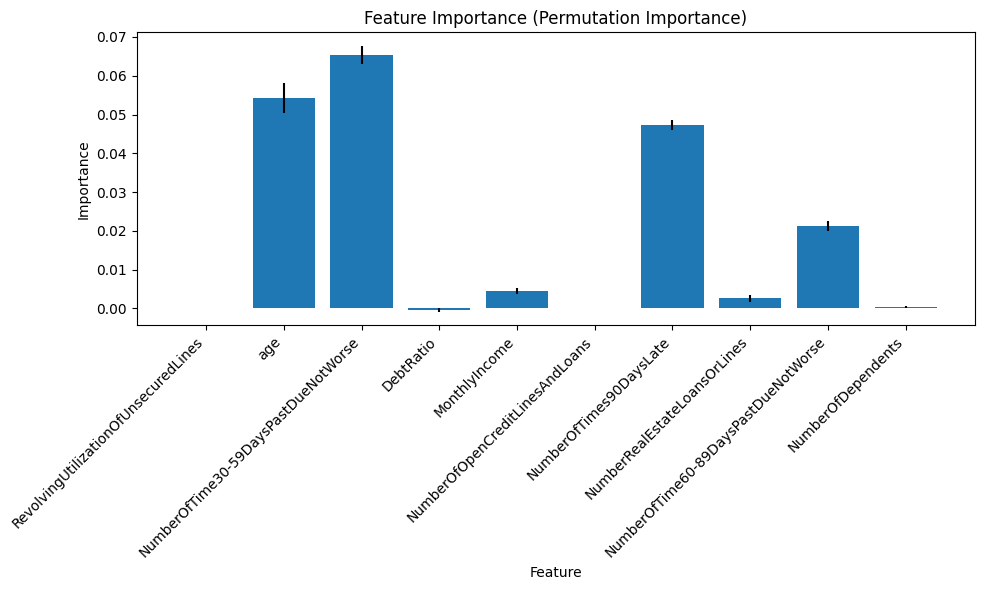

In [25]:
# 7. 시각화 1: 피처 중요도 플롯
plt.figure(figsize=(10, 6))
plt.bar(X.columns, perm_importance.importances_mean, yerr=perm_importance.importances_std)
plt.title('Feature Importance (Permutation Importance)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

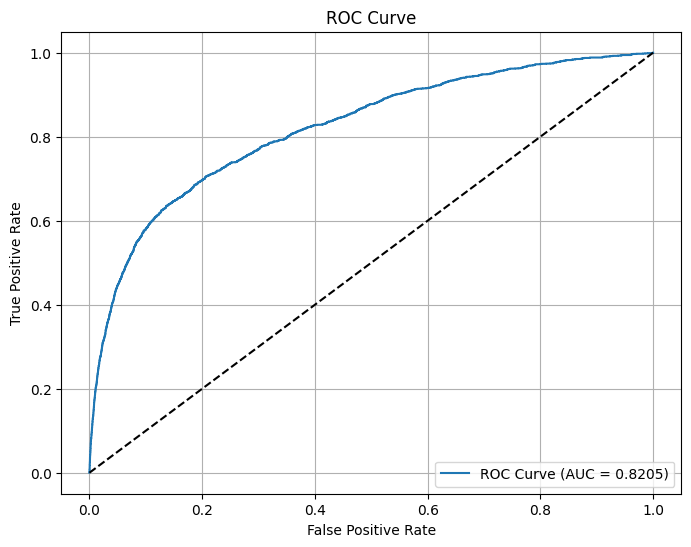

In [26]:
# 8. 시각화 2: ROC 곡선 플롯
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # 대각선
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('roc_curve.png')
plt.show()

In [24]:
# 9. 테스트 데이터 예측 및 제출 파일 생성
test_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
submission = pd.DataFrame({'Id': test_data['Unnamed: 0'], 'Probability': test_pred_proba})
submission.to_csv('submission.csv', index=False)
print("제출 파일 'submission.csv'가 생성되었습니다.")

제출 파일 'submission.csv'가 생성되었습니다.
